In [1]:
import numpy as np 
import pandas as pd  
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, roc_auc_score, roc_curve, 
                             matthews_corrcoef, log_loss)
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re
from itertools import product
import time
from sklearn.ensemble import VotingClassifier
from tqdm import tqdm
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import precision_score, recall_score, f1_score
import pickle

# Import Model

In [7]:
# Load the SVM model
with open('../Model/80k_svm_classic.pkl', 'rb') as f:
    loaded_svm_model = pickle.load(f)

# # Load the Stacking Classifier model
# with open('Notebook/stacking_clf.pkl', 'rb') as f:
#     loaded_stacking_model = pickle.load(f)

# Load the logistic regression model
with open('../Model/80000_logreg_classic.pkl', 'rb') as f:
    loaded_logreg_model = pickle.load(f)

In [8]:
def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  

    return text

In [10]:
import pandas as pd

# Create synthetic phishing and non-phishing emails
test_samples = pd.DataFrame({
    'text_combined': [
        # Non-phishing email
        "URGENT! Your account has been suspended. Click here immediately to verify your information and avoid closure: http://fakebank.verify-now.com"    ]
})

# Preview the test samples
print(test_samples)


                                       text_combined
0  URGENT! Your account has been suspended. Click...


In [11]:
unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded'] 
test_samples['text_combined'] = test_samples['text_combined'].apply(lambda x: preprocess_text(x, unwanted_terms))

In [14]:
df = pd.read_csv('../Dataset/phishing_email.csv')

In [15]:
df = df.dropna()
df = df.drop_duplicates()

In [16]:
print(df['label'].value_counts())
phishing_emails = df[df['label'] == 1]
non_phishing_emails = df[df['label'] == 0]

label
1    42845
0    39233
Name: count, dtype: int64


In [20]:
phishing_sample = phishing_emails.sample(n=39000, random_state=42)
non_phishing_sample = non_phishing_emails.sample(n=39000, random_state=42)
df_sample = pd.concat([phishing_sample, non_phishing_sample]).reset_index(drop=True)
df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

In [21]:
X = df_sample['text_combined'] 
y = df_sample['label']         
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [22]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
test_sample_tfidf = tfidf.transform(test_samples)
X_test_tfidf = tfidf.transform(X_test)

In [237]:
# c-values for svm
c_values = np.logspace(-3, 3, 10) #
accuracy_scores = []
error_rates = []
for c in c_values:
    loaded_svm_model = SVC(kernel='linear', probability=True, C=c, random_state=42)
    loaded_svm_model.fit(X_train_tfidf, y_train)
    y_pred_svm = loaded_svm_model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred_svm)
    error_rate = 1 - acc
    accuracy_scores.append(acc)
    error_rates.append(error_rate)

In [23]:
# Assuming your model is called 'stacking_model' or 'svm_model'
predictions = loaded_logreg_model.predict(test_sample_tfidf)

print("Predictions:", predictions)

Predictions: [1]


# Testing with 100 phishing email

In [24]:
df_test = pd.read_csv('phising email 100.csv')
df_test.head()

def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded']
df_test['text_combined'] = df_test['text_combined'].apply(lambda x: preprocess_text(x, unwanted_terms))

X_train = df['text_combined']
X_train = X_train.apply(lambda x: preprocess_text(x, unwanted_terms))

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(df_test['text_combined'])

FileNotFoundError: [Errno 2] No such file or directory: 'phising email 100.csv'

In [42]:
predictions = loaded_svm_model.predict(X_test_tfidf)

In [43]:
# 9. Attach predictions to test samples
df_test['predicted_label'] = predictions

# 10. Map numeric labels to readable text
label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_test['predicted_label_text'] = df_test['predicted_label'].map(label_mapping)

# 11. Show final results
print(df_test[['text_combined', 'label', 'predicted_label_text']])

NameError: name 'df_test' is not defined

In [27]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Map the true labels based on your custom rule
true_label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_test['true_label_text'] = df_test['label'].map(true_label_mapping)

# 2. Count predictions
predicted_counts = df_test['predicted_label_text'].value_counts()

# 3. Count true labels
true_counts = df_test['true_label_text'].value_counts()

# 4. Display the counts
print("=== Predicted Label Counts ===")
print(predicted_counts)
print("\n=== True Label Counts ===")
print(true_counts)

# 5. Comparison Table
comparison_df = pd.DataFrame({
    'True Count': true_counts,
    'Predicted Count': predicted_counts
}).fillna(0).astype(int)

print("\n=== Comparison Table ===")
print(comparison_df)

# 6. Calculate Accuracy
accuracy = accuracy_score(df_test['true_label_text'], df_test['predicted_label_text'])
print(f"\n=== Accuracy: {accuracy:.4f} ===")

# 7. Confusion Matrix
cm = confusion_matrix(df_test['true_label_text'], df_test['predicted_label_text'], labels=['Phishing', 'Non-Phishing'])
print("\n=== Confusion Matrix ===")
print(cm)

# 8. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing', 'Non-Phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


NameError: name 'df_test' is not defined

# From Input User

In [28]:
# Function for preprocessing (reuse your code)
def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

# List of unwanted terms
unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded']

# Get input from user
user_input = input("Please enter the email text you want to test:\n")

# Preprocess the input
preprocessed_input = preprocess_text(user_input, unwanted_terms)

# Vectorize the input using the fitted TF-IDF
input_vectorized = tfidf.transform([preprocessed_input])

# Predict
prediction = loaded_svm_model.predict(input_vectorized)[0]  # or use svm_model if you prefer

# Map numeric prediction to text
label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
predicted_label_text = label_mapping[prediction]

# Output
print(f"\n=== Prediction Result ===\nThis email is: {predicted_label_text}")



=== Prediction Result ===
This email is: Phishing


# Test with Nigerian_Fraud Data

In [30]:
df_fraud = pd.read_csv('../Dataset/Nigerian_Fraud.csv')

In [31]:
df_fraud = df_fraud.drop(columns=['sender', 'receiver', 'date', 'subject', 'urls'])

In [32]:
df_fraud.head()

def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded']
df_fraud['body'] = df_fraud['body'].apply(lambda x: preprocess_text(x, unwanted_terms))

X_train = df['text_combined']
X_train = X_train.apply(lambda x: preprocess_text(x, unwanted_terms))

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(df_fraud['body'])

In [33]:
predictions = loaded_svm_model.predict(X_test_tfidf)

# 9. Attach predictions to test samples
df_fraud['predicted_label'] = predictions

# 10. Map numeric labels to readable text
label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_fraud['predicted_label_text'] = df_fraud['predicted_label'].map(label_mapping)

# 11. Show final results
print(df_fraud[['body', 'label', 'predicted_label_text']])

                                                   body  label  \
0     frommr james ngola confidential tel email jame...      1   
1     dear friend i am mr ben suleman a custom offic...      1   
2     from his royal majesty hrm crown ruler of elem...      1   
3     from his royal majesty hrm crown ruler of elem...      1   
4     dear sir it is with a heart full of hope that ...      1   
...                                                 ...    ...   
3327  atten my dear i have paid the fee for your che...      1   
3328  from mr ali sherif african development bank ad...      1   
3329  from dr usman ibrahim dankoauditing and accoun...      1   
3330  beloved in the lord jesus christ please endeav...      1   
3331  mrhuang chilin bank sinopac executive vice pre...      1   

     predicted_label_text  
0            Non-Phishing  
1                Phishing  
2                Phishing  
3                Phishing  
4            Non-Phishing  
...                   ...  
3327       

=== Predicted Label Counts ===
predicted_label_text
Non-Phishing    2036
Phishing        1296
Name: count, dtype: int64

=== True Label Counts ===
true_label_text
Phishing    3332
Name: count, dtype: int64

=== Comparison Table ===
              True Count  Predicted Count
Non-Phishing           0             2036
Phishing            3332             1296

=== Accuracy: 0.3890 ===

=== Confusion Matrix ===
[[1296 2036]
 [   0    0]]


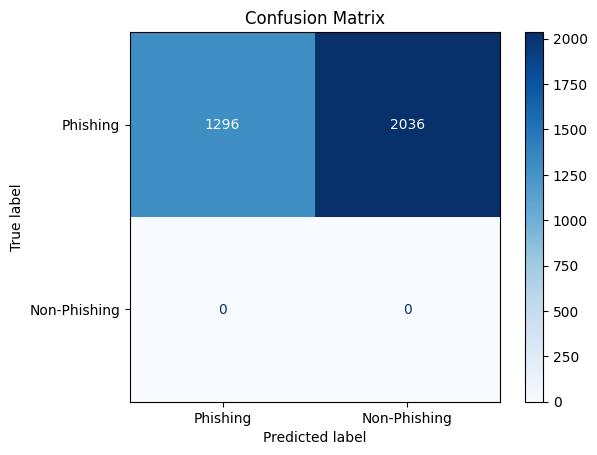

In [34]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Map the true labels based on your custom rule
true_label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_fraud['true_label_text'] = df_fraud['label'].map(true_label_mapping)

# 2. Count predictions
predicted_counts = df_fraud['predicted_label_text'].value_counts()

# 3. Count true labels
true_counts = df_fraud['true_label_text'].value_counts()

# 4. Display the counts
print("=== Predicted Label Counts ===")
print(predicted_counts)
print("\n=== True Label Counts ===")
print(true_counts)

# 5. Comparison Table
comparison_df = pd.DataFrame({
    'True Count': true_counts,
    'Predicted Count': predicted_counts
}).fillna(0).astype(int)

print("\n=== Comparison Table ===")
print(comparison_df)

# 6. Calculate Accuracy
accuracy = accuracy_score(df_fraud['true_label_text'], df_fraud['predicted_label_text'])
print(f"\n=== Accuracy: {accuracy:.4f} ===")

# 7. Confusion Matrix
cm = confusion_matrix(df_fraud['true_label_text'], df_fraud['predicted_label_text'], labels=['Phishing', 'Non-Phishing'])
print("\n=== Confusion Matrix ===")
print(cm)

# 8. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing', 'Non-Phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Test with Phishing Email

In [36]:
df_phishing = pd.read_csv('../Dataset/phishing_email.csv')

In [37]:
df_phishing.head()

def preprocess_text(text, unwanted_terms):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text) 
    text = re.sub(r'\b(?:mon|tue|wed|thu|fri|sat|sun)\b', '', text, flags=re.IGNORECASE) 
    text = re.sub(r'\b(?:jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)\b', '', text, flags=re.IGNORECASE)  
    for term in unwanted_terms:
        text = re.sub(rf'\b{term}\b', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^\w\s]', '', text)  
    text = re.sub(r'\s+', ' ', text).strip()  
    return text

unwanted_terms = ['enron', 'hpl', 'nom', 'forwarded']
df_phishing['text_combined'] = df_phishing['text_combined'].apply(lambda x: preprocess_text(x, unwanted_terms))

X_train = df['text_combined']
X_train = X_train.apply(lambda x: preprocess_text(x, unwanted_terms))

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)

X_test_tfidf = tfidf.transform(df_phishing['text_combined'])

In [38]:
predictions = loaded_logreg_model.predict(X_test_tfidf)

# 9. Attach predictions to test samples
df_phishing['predicted_label'] = predictions

# 10. Map numeric labels to readable text
label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_phishing['predicted_label_text'] = df_phishing['predicted_label'].map(label_mapping)

# 11. Show final results
print(df_phishing[['text_combined', 'label', 'predicted_label_text']])

                                           text_combined  label  \
0                  see attached file hplno xls hplno xls      0   
1      actual vols th sabrae zajac hou ect pm capital...      0   
2      actuals march april estimated actuals march fl...      0   
3                  see attached file hplno xls hplno xls      0   
4             june see attached file hplno xls hplno xls      0   
...                                                  ...    ...   
82481  info advantageapartmentscom infoadvantageapart...      1   
82482  monkeyorg helpdeskmonkeyorg monkeyorg hi josep...      1   
82483  help center infohelpcentercoza_infohelpcenterc...      1   
82484  metamask infosofamekarcom verify metamask wall...      1   
82485  fastway infofastwaycoza_infofastwaycoza_infofa...      1   

      predicted_label_text  
0                 Phishing  
1             Non-Phishing  
2             Non-Phishing  
3                 Phishing  
4                 Phishing  
...                  

=== Predicted Label Counts ===
predicted_label_text
Non-Phishing    48345
Phishing        34141
Name: count, dtype: int64

=== True Label Counts ===
true_label_text
Phishing        42891
Non-Phishing    39595
Name: count, dtype: int64

=== Comparison Table ===
              True Count  Predicted Count
Non-Phishing       39595            48345
Phishing           42891            34141

=== Accuracy: 0.6096 ===

=== Confusion Matrix ===
[[22413 20478]
 [11728 27867]]


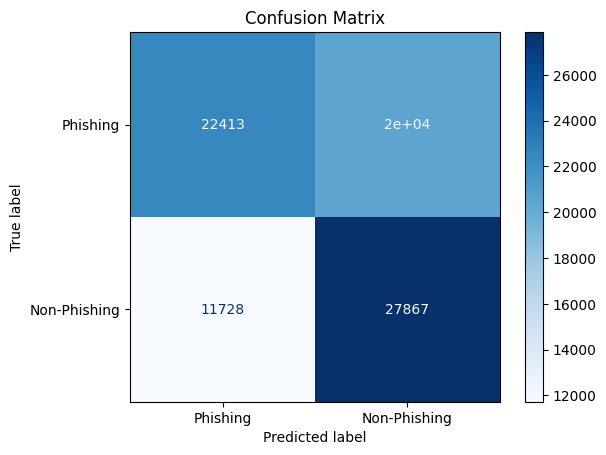

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Map the true labels based on your custom rule
true_label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_phishing['true_label_text'] = df_phishing['label'].map(true_label_mapping)

# 2. Count predictions
predicted_counts = df_phishing['predicted_label_text'].value_counts()

# 3. Count true labels
true_counts = df_phishing['true_label_text'].value_counts()

# 4. Display the counts
print("=== Predicted Label Counts ===")
print(predicted_counts)
print("\n=== True Label Counts ===")
print(true_counts)

# 5. Comparison Table
comparison_df = pd.DataFrame({
    'True Count': true_counts,
    'Predicted Count': predicted_counts
}).fillna(0).astype(int)

print("\n=== Comparison Table ===")
print(comparison_df)

# 6. Calculate Accuracy
accuracy = accuracy_score(df_phishing['true_label_text'], df_phishing['predicted_label_text'])
print(f"\n=== Accuracy: {accuracy:.4f} ===")

# 7. Confusion Matrix
cm = confusion_matrix(df_phishing['true_label_text'], df_phishing['predicted_label_text'], labels=['Phishing', 'Non-Phishing'])
print("\n=== Confusion Matrix ===")
print(cm)

# 8. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing', 'Non-Phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


svm

In [44]:
predictions = loaded_svm_model.predict(X_test_tfidf)

# 9. Attach predictions to test samples
df_phishing['predicted_label'] = predictions

# 10. Map numeric labels to readable text
label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_phishing['predicted_label_text'] = df_phishing['predicted_label'].map(label_mapping)

# 11. Show final results
print(df_phishing[['text_combined', 'label', 'predicted_label_text']])

                                           text_combined  label  \
0                  see attached file hplno xls hplno xls      0   
1      actual vols th sabrae zajac hou ect pm capital...      0   
2      actuals march april estimated actuals march fl...      0   
3                  see attached file hplno xls hplno xls      0   
4             june see attached file hplno xls hplno xls      0   
...                                                  ...    ...   
82481  info advantageapartmentscom infoadvantageapart...      1   
82482  monkeyorg helpdeskmonkeyorg monkeyorg hi josep...      1   
82483  help center infohelpcentercoza_infohelpcenterc...      1   
82484  metamask infosofamekarcom verify metamask wall...      1   
82485  fastway infofastwaycoza_infofastwaycoza_infofa...      1   

      predicted_label_text  
0                 Phishing  
1             Non-Phishing  
2             Non-Phishing  
3                 Phishing  
4                 Phishing  
...                  

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Map the true labels based on your custom rule
true_label_mapping = {0: 'Non-Phishing', 1: 'Phishing'}
df_phishing['true_label_text'] = df_phishing['label'].map(true_label_mapping)

# 2. Count predictions
predicted_counts = df_phishing['predicted_label_text'].value_counts()

# 3. Count true labels
true_counts = df_phishing['true_label_text'].value_counts()

# 4. Display the counts
print("=== Predicted Label Counts ===")
print(predicted_counts)
print("\n=== True Label Counts ===")
print(true_counts)

# 5. Comparison Table
comparison_df = pd.DataFrame({
    'True Count': true_counts,
    'Predicted Count': predicted_counts
}).fillna(0).astype(int)

print("\n=== Comparison Table ===")
print(comparison_df)

# 6. Calculate Accuracy
accuracy = accuracy_score(df_phishing['true_label_text'], df_phishing['predicted_label_text'])
print(f"\n=== Accuracy: {accuracy:.4f} ===")

# 7. Confusion Matrix
cm = confusion_matrix(df_phishing['true_label_text'], df_phishing['predicted_label_text'], labels=['Phishing', 'Non-Phishing'])
print("\n=== Confusion Matrix ===")
print(cm)

# 8. Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Phishing', 'Non-Phishing'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
